# 如何用Python探索星體的生命軌跡圖？
此notebook為[《資料視覺化：用Python為星空作畫》](https://github.com/YihaoSu/exploring-astronomy-with-python-from-data-query-to-visualization)一書的相關程式碼，由[蘇羿豪](https://astrobackhacker.tw/)編寫，並以[MIT授權條款](https://github.com/YihaoSu/exploring-astronomy-with-python-from-data-query-to-visualization/blob/main/LICENSE)釋出(我原本擬定的書名為《用Python探索天文：從資料取得到視覺化》，後應出版社要求改為現名）。我會持續透過創作故事、遊戲等有趣體驗來向大眾推廣開放科學，歡迎你加入「[Astrohackers-TW: Python在天文領域的應用](https://www.facebook.com/groups/astrohackers.tw.py)」FB社團，並追蹤我的[Threads](https://www.threads.net/@astrobackhacker)。

## 範例：用Astroquery取得Gaia太空望遠鏡的觀測資料繪製出M5球狀星團的赫羅圖
* [星團](https://zh.wikipedia.org/zh-tw/%E6%98%9F%E5%9B%A2)是一群依靠彼此引力維繫在一起的恆星所組成的集團，主要分為兩大類：球狀星團(globular cluster)和疏散星團(open cluster)。球狀星團，顧名思義，形狀像一個球體，通常包含數萬至數百萬顆的老年恆星，密集地聚集在一起。而疏散星團中的恆星數量較少，通常只有數百到數千顆星，並且分佈更加寬鬆。它們多由較年輕的恆星組成，依靠微弱的引力連結著，呈現出不規則的形狀。
* [赫羅圖(Hertzsprung–Russell diagram)](https://zh.wikipedia.org/zh-tw/%E8%B5%AB%E7%BE%85%E5%9C%96)是一種用來研究恆星演化過程的散布圖，橫軸顯示恆星表面溫度或顏色，縱軸則顯示其光度或星等，不同演化階段的恆星會落在圖中不同的區域，所以這張圖代表著星團成員的生命軌跡圖。
* [SIMBAD資料庫](https://simbad.cds.unistra.fr/simbad/)是由法國斯特拉斯堡天文資料中心所維護，可以查詢到關於恆星、星系、星雲、太陽系外行星等各種天體的基本資訊，比如它們的位置、距離、光譜類型、亮度以及其他物理參數。此外，SIMBAD還提供這些資訊所引用的參考文獻。
* [Gaia太空望遠鏡](https://zh.wikipedia.org/zh-tw/%E7%9B%96%E4%BA%9A%E4%BB%BB%E5%8A%A1)是由歐洲太空總署發起的，主要目的是精確測量數十億顆恆星的位置、距離和運動，以建立銀河系的三維星圖。
* [Astroquery](https://astroquery.readthedocs.io/en/latest/)是一個能串接不同天文資料庫服務以方便取得各種天文資料的Python套件。它提供多個模組，用於查詢不同的天文資料庫服務。其中，[simbad模組](https://astroquery.readthedocs.io/en/latest/simbad/simbad.html)可以連接SIMBAD資料庫取得星團的基本資訊，而[gaia模組](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)則可以取得Gaia太空望遠鏡的觀測資料。執行以下指令以安裝Astroquery：

In [ ]:
pip install -U --pre astroquery

In [1]:
'''
從SIMBAD資料庫取得M5球狀星團的基本資訊
'''
from astroquery.simbad import Simbad
from astropy import units as u

# 初始化Simbad查詢物件，並添加查詢所需的額外欄位，以便包含星體的赤經、赤緯、角直徑、視差與自行運動等資訊
customSimbad = Simbad()
customSimbad.add_votable_fields('ra(d)', 'dec(d)', 'dim', 'plx', 'pm')

# 執行M5星團資訊的查詢
result = customSimbad.query_object('M5')

# 取得和輸出所需資訊
ra_deg = result['RA_d'][0]
dec_deg = result['DEC_d'][0]
angular_size = result['GALDIM_MAJAXIS'][0]
parallax = result['PLX_VALUE'][0] * u.mas
distance_pc = parallax.to(u.pc, equivalencies=u.parallax())
pmra = result['PMRA'][0]
pmdec = result['PMDEC'][0]

print(f'M5星團的赤經: {ra_deg} 度')
print(f'M5星團的赤緯: {dec_deg} 度')
print(f'M5星團的角直徑: {angular_size} 弧分')
print(f'M5星團的視差: {parallax.value} 毫角秒')
print(f'M5星團的距離: {distance_pc.value} 秒差距')
print(f'M5星團的自行(赤經): {pmra} 毫角秒/年')
print(f'M5星團的自行(赤緯): {pmdec} 毫角秒/年')

M5星團的赤經: 229.63842 度
M5星團的赤緯: 2.08103 度
M5星團的角直徑: 17.399999618530273 弧分
M5星團的視差: 0.141 毫角秒
M5星團的距離: 7092.198581560283 秒差距
M5星團的自行(赤經): 4.06 毫角秒/年
M5星團的自行(赤緯): -9.89 毫角秒/年


INFO: Query finished. [astroquery.utils.tap.core]


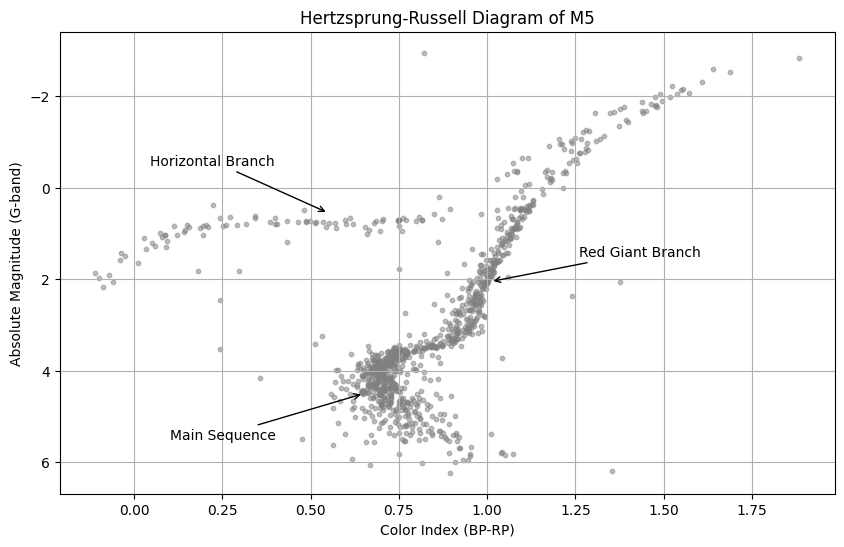

In [2]:
'''
根據M5球狀星團的基本資訊，過濾Gaia太空望遠鏡的資料以便繪製出其赫羅圖
'''
import astropy.coordinates as coord
import astropy.units as u
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from math import log10

# 定義M5星團的中心位置和搜索半徑
center = coord.SkyCoord(ra=ra_deg*u.degree, dec=dec_deg*u.degree, frame='icrs')
radius = (angular_size/2)*u.arcmin

# 定義Gaia DR3的SQL資料查詢語句
# 為了繪製赫羅圖，這邊選取了G波段的平均視星等(phot_g_mean_mag)和色指數(bp_rp)的資料
# 色指數(bp_rp)是指偏藍光的BP波段和偏紅光的RP波段的星等差，這個數值反映了恆星的顏色和溫度。
query = f"""
SELECT
    source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, bp_rp
FROM
    gaiadr3.gaia_source
WHERE
    CONTAINS(
      POINT('ICRS', ra, dec),
      CIRCLE('ICRS', {center.ra.deg}, {center.dec.deg}, {radius.to(u.deg).value})
    ) = 1
AND parallax BETWEEN {parallax.value - 0.03} AND {parallax.value + 0.03} -- 假設視差的容許範圍為±0.03毫角秒
AND pmra BETWEEN {pmra - 0.5} AND {pmra + 0.5} -- 假設赤經自行量的容許範圍為±0.5毫角秒/年
AND pmdec BETWEEN {pmdec - 0.5} AND {pmdec + 0.5} -- 假設赤緯自行量的容許範圍為±0.5毫角秒/年
"""
Gaia.ROW_LIMIT = -1
job = Gaia.launch_job_async(query=query)
gaia_data = job.get_results()

# 計算絕對星等
absolute_magnitude = gaia_data['phot_g_mean_mag'] - 5 * log10(distance_pc / (10 * u.pc))

# 繪製赫羅圖，並標示幾個恆星演化階段的位置
plt.figure(figsize=(10, 6))
plt.scatter(gaia_data['bp_rp'], absolute_magnitude, s=10, color='grey', alpha=0.5)
plt.gca().invert_yaxis()  # 星等越低，恆星越亮，所以需要反轉Y軸
plt.annotate('Main Sequence', xy=(0.65, 4.5), xytext=(0.1, 5.5), fontsize=10, arrowprops=dict(facecolor='grey', arrowstyle='->', lw=1))  # 標註主序星區域
plt.annotate('Red Giant Branch', xy=(1.01, 2.05), xytext=(1.26, 1.5), fontsize=10, arrowprops=dict(facecolor='grey', arrowstyle='->', lw=1))  # 標註紅巨星分支區域
plt.annotate('Horizontal Branch', xy=(0.55, 0.55), xytext=(0.045, -0.5), fontsize=10, arrowprops=dict(facecolor='grey', arrowstyle='->', lw=1))  # 標註水平分支區域
plt.title('Hertzsprung-Russell Diagram of M5')
plt.xlabel('Color Index (BP-RP)')
plt.ylabel('Absolute Magnitude (G-band)')
plt.grid(True)
plt.show()